In [1]:
#compare spherical Voronoi performance of my personal repo against the latest commit of the scipy fork (hash: c7a35c)
import sys; sys.path.append('D:\\github\\py_sphere_Voronoi')
import voronoi_utility
import scipy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%load_ext line_profiler
%autoreload 2

In [2]:
dictionary_spherical_Voronoi_performance_profiles = {}


In [15]:
#for the old code in my personal repo
import math
import time
array_generator_counts = np.array([10,100,1000, 2000]) #getting crashes at large numbers of generators
prng = np.random.RandomState(117)
center = np.zeros(3)

for generator_count in array_generator_counts:
    current_array_random_generators = voronoi_utility.generate_random_array_spherical_generators(generator_count,1.0,prng)
    start_time = time.time()
    
    current_Voronoi_instance = voronoi_utility.Voronoi_Sphere_Surface(current_array_random_generators,1.0)
    
    %lprun -f voronoi_utility.Voronoi_Sphere_Surface.voronoi_region_vertices_spherical_surface dict_generators_and_voronoi_regions = current_Voronoi_instance.voronoi_region_vertices_spherical_surface()
    end_time = time.time()
    time_to_produce_voronoi_regions = end_time - start_time

    dictionary_spherical_Voronoi_performance_profiles[generator_count] = {}
    dictionary_spherical_Voronoi_performance_profiles[generator_count]['time_to_produce_voronoi_regions'] = time_to_produce_voronoi_regions
    
    print 'generator_count:', generator_count, 'processed. ', time_to_produce_voronoi_regions

generator_count: 10 processed.  0.0090000629425
generator_count: 100 processed.  0.0429999828339
generator_count: 1000 processed.  0.422000169754
generator_count: 2000 processed.  0.880000114441


In [11]:
import time
array_generator_counts_scipy_fork = np.array([10,100,1000, 2000]) #much shorter list for SLOWER performing scipy code for now
prng = np.random.RandomState(117)
center = np.zeros(3)
sys.path.append('D:\\github\\bench_spherical_voronoi')
import spherical_voronoi

for generator_count in array_generator_counts_scipy_fork:
    current_array_random_generators = voronoi_utility.generate_random_array_spherical_generators(generator_count,1.0,prng)
    
    #for the new code in my scipy fork
    start_time = time.time()
    %lprun -f spherical_voronoi.SphericalVoronoi._calc_vertices_regions sv = spherical_voronoi.SphericalVoronoi(current_array_random_generators, 1.0, center) #calculates unsorted regions
    #sv.sort_vertices_of_regions() #sorted regions produced 
    #list_sorted_voronoi_regions_scipy_fork = sv.regions #commenting in case this assignment is slowing doing the new scipy bench unfairly
    end_time = time.time()
    time_to_produce_voronoi_regions_scipy_fork = end_time - start_time
    
    dictionary_spherical_Voronoi_performance_profiles[generator_count]['time_to_produce_voronoi_regions_scipy_fork'] = time_to_produce_voronoi_regions_scipy_fork
    
    print 'generator_count:', generator_count, 'processed.', time_to_produce_voronoi_regions_scipy_fork

generator_count: 10 processed. 0.00399994850159
generator_count: 100 processed. 0.0729999542236
generator_count: 1000 processed. 7.08200001717
generator_count: 2000 processed. 28.614000082


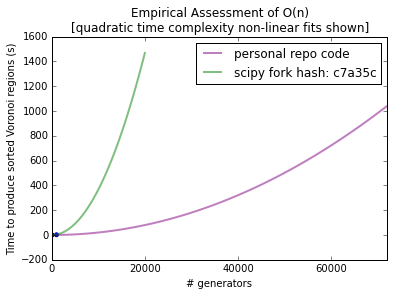

In [11]:
#produce a plot of the performance results (i.e., empirical assessment of O(n))
import scipy.optimize
import matplotlib.ticker as mtick
fig_performance = plt.figure()
ax = fig_performance.add_subplot('111')

def quadratic(n, K):
    '''Quadratic fit with K as the constant.'''
    return K * (n ** 2)

y_data = []
y_data_scipy = []
for value in array_generator_counts:
    y_data.append(dictionary_spherical_Voronoi_performance_profiles[value]['time_to_produce_voronoi_regions'])
    if value <= 15000:
        y_data_scipy.append(dictionary_spherical_Voronoi_performance_profiles[value]['time_to_produce_voronoi_regions_scipy_fork'])

for generator_count, subdictionary in dictionary_spherical_Voronoi_performance_profiles.iteritems():
    time_to_produce_Voronoi_regions = subdictionary['time_to_produce_voronoi_regions']
    ax.scatter(generator_count, time_to_produce_Voronoi_regions, edgecolor = 'none', c = 'k')
    if generator_count <= 15000:
        time_to_produce_Voronoi_regions_scipy = subdictionary['time_to_produce_voronoi_regions_scipy_fork']
        ax.scatter(generator_count, time_to_produce_Voronoi_regions_scipy, edgecolor = 'none', c = 'blue')
        
    
K_quadratic, pcov_quadratic = scipy.optimize.curve_fit(quadratic, array_generator_counts, y_data)
K_quadratic_scipy, pcov_quadratic_scipy = scipy.optimize.curve_fit(quadratic, array_generator_counts_scipy_fork, y_data_scipy)

ax.set_xlabel('# generators')
ax.set_ylabel('Time to produce sorted Voronoi regions (s)')
ax.set_xlim(-10,72000)
#ax.set_ylim(-2,150)
ax.set_title('Empirical Assessment of O(n)\n[quadratic time complexity non-linear fits shown]')

#plot the fit to the data for performance model(s)
sample_x_data = np.linspace(5,72000,num = 50)
sample_x_data_scipy = np.linspace(5,20000,num = 30)
ax.set_xticks([0,20000,40000, 60000])
sample_y_data_quadratic = quadratic(sample_x_data, K_quadratic[0])
sample_y_data_quadratic_scipy = quadratic(sample_x_data_scipy, K_quadratic_scipy[0])
ax.plot(sample_x_data, sample_y_data_quadratic, c = 'purple', label = 'personal repo code', alpha = 0.5, lw = 2)
ax.plot(sample_x_data_scipy, sample_y_data_quadratic_scipy, c = 'green', label = 'scipy fork hash: c7a35c', alpha = 0.5, lw = 2)
ax.legend(loc = 1)

In [23]:
fig_performance.savefig('performance_spherical_voronoi.png', dpi = 300)